# Code
- **Primär für numerische Features**: 
   - Wasserstein-Distanz [0.0, ∞): 0.0 = identische Verteilungen; Höher = mehr „Transportarbeit“ zwischen Verteilungen
      - Geeignet für: Numerische oder ordinal sortierte Daten (z. B. Einkommen, Alter)
      - Misst, wie viel „Wahrscheinlichkeit“ verschoben werden muss, um die Verteilungen anzugleichen.
      - Für kategoriale Daten nicht sinnvoll, es sei denn, eine Ordnung ist definiert.
   - Hausdorff-Distanz [0.0, ∞): 0.0 = Punktmengen sind identisch oder vollständig überlappend; Höher = größerer Abstand der am weitesten entfernten Punkte
      - Geeignet für: Mengen von Punkten (z. B. geometrische Formen, Sets)
      - Extrem sensitiv auf Ausreißer – misst den maximalen minimalen Abstand. Für Verteilungen oder Durchschnittsverhalten nicht ideal.
   - Cosine-Distanz [0.0, 1.0]: 0.0 = gleiche Richtung (hohe Ähnlichkeit); 1.0 = orthogonal (keine Ähnlichkeit)
      - Geeignet für: Vektorielle Daten (z. B. Text-Vektoren, Häufigkeiten)
      - Anmerkung: Unempfindlich gegenüber Betrag; misst nur den Winkel zwischen Vektoren. Gut für z. B. TF-IDF.

- **Primär für kategoriale Features:**
   - KL-Divergenz [0.0, ∞): 0.0 = Verteilungen sind identisch; Größere Werte = größere Abweichung von q zu p
   - Reverse-KL-Divergenz [0.0, ∞): 0.0 = Verteilungen sind identisch; Größere Werte = größere Abweichung von p zu q (andere Richtung!)
   - Jensen-Shannon-Divergenz [0.0, 1.0]: 0.0 = Verteilungen sind identisch; 1.0 = Verteilungen sind maximal unterschiedlich
   - Hellinger-Distanz [0.0, 1.0]: 0.0 = Verteilungen sind identisch; 1.0 = Verteilungen sind maximal unterschiedlich
   - Bhattacharyya-Distanz [0.0, ∞): 0.0 = identisch; Größere Werte = stärkere Unähnlichkeit
   - Chi-Quadrat-Distanz [0.0, ∞): 0.0 = identisch; Größere Werte = größere Abweichung

- **Für numerisch und kategorial:**
   - Gower-Distanz [0.0, 1.0]: 0.0 = identisch; 1.0 = maximal unterschiedlich
      - Geeignet für: Gemischte Datentypen (numerisch, ordinal, binär, kategorial)
      - Anmerkung: Skaliert jede Variable einzeln und aggregiert – ideal für heterogene Datensätze. Robust und gut interpretierbar.

Nach Binning sind viele kategoriale Metriken jedoch ebenfalls auf numerische Features anwendbar. Die Wahl der Bin‑Breite (z. B. 20 vs. 100 Bins) kann das Ergebnis stark beeinflussen:
- Zu grobe Bins glätten Details
- zu feine führen zu vielen Null‑Zellen (deshalb immer ein kleines 𝜀 addieren)

**Weiteres:**
- Für Cosine Similarity wird bei normalize=True aus [-1, 1] -> [0, 1] gemappt
- Hellinger, Gower und JS (hier auf Basis von Natural‑Log umgerechnet) liegen bereits in [0,1] und bleiben unverändert.
- Alle anderen Distanzen/Divergenzen werden mit d/(1+d) in [0,1] transformiert.

# Imports

In [1]:
import pandas as pd
from pathlib import Path
import numpy as np
from pathlib import Path
from typing import Optional, Tuple, Union
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import directed_hausdorff
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
import gower
from scipy.special import rel_entr
from scipy.spatial.distance import jensenshannon

# User Configuration

In [5]:
SAVE_FIGS = True
SAVE_CSVS = True

REAL_FILE = "20250301_data_20250510_122405_final_100_train.csv"
SYNTH_FILE = "20250301_data_20250510_122405_final_100_synth.csv"
HOLDOUT_FILE = "20250301_data_20250510_122405_final_100_holdout.csv"

DATA_DIR = Path("../../data")
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)  # ensure output folder exists
OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)  # ensure output folder exists

# Set my design
sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        "font.size": 7,
        "axes.titlesize": 7,
        "axes.labelsize": 7,
        "xtick.labelsize": 7,
        "ytick.labelsize": 7,
        "legend.fontsize": 7
    }
)


# Utility Functions

## Data Loading

In [ ]:
def convert_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """
    Konvertiert bestimmte Spalten des DataFrames in die gewünschten Datentypen:
     - definierte Spalten als category
     - definierte Spalten als pandas Nullable Integer (Int64)
     - consciousness_level und news_score als geordnete Categoricals
    """
    df = df.copy()  # Änderungen nicht am Original vornehmen

    # 1) Kategorische Spalten
    cat_cols = ['gender', 'ethnicity', 'chief_complaint', 'icd_block']
    for col in cat_cols:
        df[col] = df[col].astype('category')

    # 2) Integer-Spalten mit Nullable Integer dtype
    int_cols = ['age', 'systolic_bp', 'diastolic_bp',
                'heart_rate', 'respiratory_rate', 'oxygen_saturation']
    for col in int_cols:
        df[col] = df[col].astype('Int64')

    # 3) Geordnete Categoricals
    df['consciousness_level'] = pd.Categorical(
        df['consciousness_level'],
        categories=['A', 'C', 'V', 'P', 'U'],
        ordered=True
    )
    df['news_score'] = pd.Categorical(
        df['news_score'],
        categories=list(range(19)),
        ordered=True
    )

    return df

def load_data(
    real_filename: Union[str, Path],
    synth_filename: Optional[Union[str, Path]] = None,
    holdout_filename: Optional[Union[str, Path]] = None,
    data_dir: Path = DATA_DIR
) -> Tuple[pd.DataFrame, Optional[pd.DataFrame], Optional[pd.DataFrame]]:
    """
    Lädt die realen, synthetischen und optionalen Holdout-CSV-Dateien
    aus data_dir und wandelt sie über convert_dtypes um.

    Returns:
        df_real: pd.DataFrame
        df_synth: Optional[pd.DataFrame]
        df_holdout: Optional[pd.DataFrame]
    """
    def _read_and_convert(fn: Union[str, Path]) -> pd.DataFrame:
        return (
            pd.read_csv(data_dir / fn, low_memory=False)
              .pipe(convert_dtypes)
        )

    df_real    = _read_and_convert(real_filename)
    df_synth   = _read_and_convert(synth_filename)   if synth_filename   else None
    df_holdout = _read_and_convert(holdout_filename) if holdout_filename else None

    return df_real, df_synth, df_holdout

## Numeric Metrics

In [ ]:
def scale_minmax(df_real, df_synth, feature):
    """Skaliert die Daten mit Min-Max-Skalierung."""
    scaler = MinMaxScaler()
    r = scaler.fit_transform(df_real[[feature]])
    s = scaler.fit_transform(df_synth[[feature]])
    return r, s

def calc_wasserstein(r, s):
    """Berechnet die Wasserstein-Distanz."""
    return wasserstein_distance(r.ravel(), s.ravel())

def calc_hausdorff(r, s):
    """Berechnet die Hausdorff-Distanz."""
    d_AB = directed_hausdorff(r, s)[0]
    d_BA = directed_hausdorff(s, r)[0]
    return max(d_AB, d_BA)

def calc_cosine(r, s):
    """Berechnet die Cosine-Distanz."""
    similarity = cosine_similarity(r.T, s.T)[0][0]  # Eigentlich zwischen -1 (schlecht) und 1 (identisch) Wertebereich; bei Min-Max-Skalierung zwischen jedoch nur zwischen 0 und 1
    return 1 - similarity  # (komplett unterschiedlich): 1, Identisch: 0

def compare_distributions_num(df_real, df_synth, feature):
    r, s = scale_minmax(df_real, df_synth, feature)
    return {
        "feature": feature,
        "wasserstein_distance": calc_wasserstein(r, s),
        "hausdorff_distance": calc_hausdorff(r, s),
        "cosine_distance": calc_cosine(r, s),
    }

## Categorical Metrics

In [ ]:
def compute_distributions(df_real, df_synth, feature):
    """Berechnet die Wahrscheinlichkeitsverteilungen für ein kategoriales Feature."""
    real_counts = df_real[feature].value_counts(normalize=True)
    synth_counts = df_synth[feature].value_counts(normalize=True)
    all_categories = sorted(set(real_counts.index).union(set(synth_counts.index)))
    p = np.array([real_counts.get(cat, 0) for cat in all_categories])
    q = np.array([synth_counts.get(cat, 0) for cat in all_categories])
    return p, q

def hellinger_distance(p, q):
    """Berechnet die Hellinger-Distanz zwischen zwei Verteilungen."""
    return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q))**2))

def kl_divergence(p, q):
    """Berechnet die KL-Divergenz D_KL(p || q). Fügt kleinen Wert hinzu, um Division durch 0 zu vermeiden."""
    epsilon = 1e-10
    p = p + epsilon
    q = q + epsilon
    return np.sum(rel_entr(p, q))

def reverse_kl_divergence(p, q):
    """Reverse KL-Divergenz D_KL(q || p)."""
    return kl_divergence(q, p)

def js_distance(p, q):
    """Jensen-Shannon-Distanz (symmetrische Wurzel der JS-Divergenz)."""
    return jensenshannon(p, q)  # Gibt direkt die Quadratwurzel der JS-Divergenz zurück

def bhattacharyya_distance(p, q):
    """Bhattacharyya-Distanz: kleiner = ähnlicher"""
    bc = np.sum(np.sqrt(p * q))
    return -np.log(bc + 1e-10)

def chi2_distance(p, q):
    """Chi²-Distanz: robust gegen unterschiedliche Längen der Verteilungen"""
    mask = (p + q) > 0  # Vermeidet Division durch 0
    return 0.5 * np.sum(((p[mask] - q[mask])**2) / (p[mask] + q[mask]))

def compare_distributions_cat(df_real, df_synth, feature):
    p, q = compute_distributions(df_real, df_synth, feature)
    return {
        "feature": feature,
        "hellinger_distance": hellinger_distance(p, q),
        "kl_divergence": kl_divergence(p, q),
        "reverse_kl_divergence": reverse_kl_divergence(p, q),
        "js_distance": js_distance(p, q),
        "bhattacharyya_distance": bhattacharyya_distance(p, q),
        "chi2_distance": chi2_distance(p, q)
    }

## Gower

In [ ]:
def calc_gower(df_real, df_synth, feature):
    """Berechnet die Gower-Distanz."""

    # Featuretyp erkennen
    dtype = df_real[feature].dtype

    if pd.api.types.is_numeric_dtype(dtype):
        # Numerische Features
        # 1. Min-Max-Skalierung
        r, s = scale_minmax(df_real, df_synth, feature)
        # 2. Umrechnung in float, da Int64 nicht unterstützt wird
        r = r.astype(float)
        s = s.astype(float)
    else:
        # Kategoriale Features
        r = df_real[[feature]].copy().astype(object)
        s = df_synth[[feature]].copy().astype(object)

    # Gower-Distanzmatrix
    dist_matrix = gower.gower_matrix(r, s)

    return {
        "feature": feature,
        "gower_distance": dist_matrix.mean(),
    }

# Main Routine

In [ ]:
df_real, df_synth, df_holdout = load_data(
    REAL_FILE,
    SYNTH_FILE,
    HOLDOUT_FILE,
    data_dir=DATA_DIR
)
num_attrs = df_real.select_dtypes(include=['number']).columns
cat_attrs = df_real.select_dtypes(exclude=['number']).columns

## Categoricals

In [ ]:
res_cat = []

for attr in cat_attrs:
    res = compare_distributions_cat(df_real, df_synth, attr)
    res_cat.append(res)

df_results_cat = pd.DataFrame(res_cat)
print(df_results_cat)

## Numerics

In [ ]:
res_num = []

for attr in num_attrs:
    res = compare_distributions_num(df_real, df_synth, attr)
    res_num.append(res)

df_results_num = pd.DataFrame(res_num)
print(df_results_num)

## Gower

In [ ]:
# Laufzeit: 3 min per feature = 3 * 16 = 48 min
res_gower = []
all_attrs = df_real.columns.tolist()

for attr in all_attrs:
    print(f"Calculating Gower distance for {attr}...")
    # res = calc_gower(df_real.sample(5000), df_synth.sample(5000), attr)
    res = calc_gower(df_real, df_synth, attr)
    res_gower.append(res)

df_results_gower = pd.DataFrame(res_gower)
print(df_results_gower)

## Plotting

In [ ]:
df_combined_cat = df_results_cat.merge(df_results_gower[['feature', 'gower_distance']], on='feature', how='left')
# print(df_combined_cat)

df_combined_num = df_results_num.merge(df_results_gower[['feature', 'gower_distance']], on='feature', how='left')
# print(df_combined_num)

### Numeric

In [ ]:
df_plot_num = df_combined_num.set_index('feature')
if SAVE_CSVS:
    df_plot_num.to_csv(OUTPUT_DIR_CSV / "numerical_features_distances.csv", index=True, sep=';', decimal=',', encoding='utf-8')

#### Load instead precalculated

In [ ]:
# df_plot_num = pd.read_csv(OUTPUT_DIR_CSV / "numerical_features_distances.csv", sep=';', decimal=',', encoding='utf-8')
# df_plot_num.set_index('feature', inplace=True)

#### Plot

In [11]:
# Umbenenen der Spalten
df_plot_num = df_plot_num.rename(
    columns={
        "wasserstein_distance": "Wasserstein",
        "hausdorff_distance": "Hausdorff",
        "cosine_distance": "Cosinus",
        "gower_distance": "Gower"
    }
)

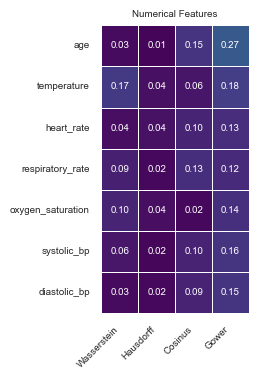

In [29]:
fig, ax = plt.subplots(figsize=(2.6, 3.8))
sns.heatmap(df_plot_num, annot=True, fmt=".2f", linewidths=0.5, vmin=0, vmax=1,
            cmap="viridis", cbar_kws={'label': 'Distance'}, cbar=False, ax=ax)
ax.set_title("Numerical Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("")
ax.set_xlabel("")
plt.tight_layout()
if SAVE_FIGS:
    OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)
    fig.savefig(OUTPUT_DIR_FIG / "num_features_distance_heatmap.tiff",
                dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.show()
plt.close(fig)

### Categorical

In [ ]:
df_plot_cat = df_combined_cat.set_index('feature')
if SAVE_CSVS:
    df_plot_cat.to_csv(OUTPUT_DIR_CSV / "categorical_features_distances.csv", index=True, sep=';', decimal=',', encoding='utf-8')

#### Precalculated

In [20]:
df_plot_cat = pd.read_csv(OUTPUT_DIR_CSV / "categorical_features_distances.csv", sep=';', decimal=',', encoding='utf-8')
df_plot_cat.set_index('feature', inplace=True)

In [21]:
df_plot_cat = df_plot_cat.rename(
    columns={
        "hellinger_distance": "Hellinger",
        "kl_divergence": "Kulback-L.",
        "reverse_kl_divergence": "Rev. KL",
        "js_distance": "Jens.-Sh.",
        "bhattacharyya_distance": "Bhattac.",
        "chi2_distance": "Chi-Square",
        "gower_distance": "Gower"
    }
)

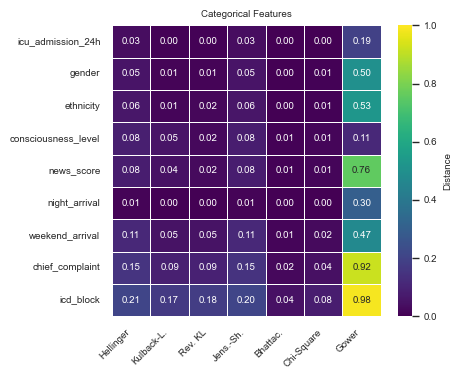

In [30]:
fig, ax = plt.subplots(figsize=(4.6, 3.8))
sns.heatmap(df_plot_cat, annot=True, fmt=".2f", linewidths=0.5, vmin=0, vmax=1,
            cmap="viridis", cbar_kws={'label': 'Distance'}, ax=ax)
ax.set_title("Categorical Features")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
ax.set_ylabel("")
ax.set_xlabel("")
plt.tight_layout()
if SAVE_FIGS:
    OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)
    fig.savefig(OUTPUT_DIR_FIG / "cat_features_distance_heatmap.tiff",
                dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.show()
plt.close(fig)

In [24]:
display(df_plot_cat)

,hellinger_distance,kl_divergence,reverse_kl_divergence,js_distance,bhattacharyya_distance,chi2_distance,gower_distance
feature,,,,,,,
icu_admission_24h,0.033788,0.004757,0.004389,0.033764,0.001142,0.002274,0.194298
gender,0.053342,0.011448,0.011327,0.053329,0.002849,0.005682,0.497913
ethnicity,0.058898,0.012447,0.015736,0.058462,0.003475,0.006647,0.527034
consciousness_level,0.083832,0.052069,0.022826,0.081614,0.007053,0.012497,0.109948
news_score,0.080627,0.044944,0.023859,0.078832,0.006522,0.011939,0.755393
night_arrival,0.008084,0.000263,0.000260,0.008084,0.000065,0.000131,0.298675
weekend_arrival,0.109946,0.047004,0.049965,0.109796,0.012162,0.023981,0.472358
chief_complaint,0.148633,0.087221,0.091873,0.147684,0.022339,0.042570,0.920217
icd_block,0.206725,0.170120,0.178222,0.204926,0.043675,0.081337,0.984838
